# **DNF F1 analasys project** 

## Part 1 - Loading and maipulating data

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats

In [5]:
#Importing data to dataframe
data = pd.read_csv('data.csv')
print(data.head(1).to_string() ,"\n")
print("Shape of daraframe: ", data.shape)

   resultId  raceId  year  round  grid  positionOrder  points  laps milliseconds fastestLap rank fastestLapTime fastestLapSpeed  driverRef    surname forename         dob nationality_x constructorRef         name nationality_y   circuitRef  circuitId   name_y  location  country      lat      lng  alt        date  target_finish
0      2460     136  2002     13    11              4     3.0  77.0          NaN         \N   \N             \N              \N  raikkonen  Räikkönen     Kimi  1979-10-17       Finnish        mclaren  Hungaroring       British  hungaroring         11  McLaren  Budapest  Hungary  47.5789  19.2486  264  2002-08-18              1 

Shape of daraframe:  (10000, 31)


As we can see, we have 10 000 rows/cars and 31 columns/features. A lot of these columns have NULL, NAN
 or \N values, we therefore have to remove these to get the desired features that can be used in our models.

In [6]:

# Count columns that contains either NaN, '\N' or 'NULL'
null_counts = (data.isna() | data.eq('\\N') | data.eq('NULL')).sum()

print(null_counts.sort_values(ascending=False))
print("Columncount:  ",len(data.columns))


milliseconds       7393
fastestLapSpeed    7191
fastestLap         6895
fastestLapTime     6895
rank               6798
laps                978
points              971
circuitRef            0
circuitId             0
name_y                0
location              0
country               0
resultId              0
name                  0
lat                   0
lng                   0
alt                   0
date                  0
nationality_y         0
forename              0
constructorRef        0
nationality_x         0
dob                   0
raceId                0
surname               0
driverRef             0
positionOrder         0
grid                  0
round                 0
year                  0
target_finish         0
dtype: int64
Columncount:   31


We decide to remove the first 7 since they are leakage columns, meaning they will give our prediction away too easily, and also because they have a lot of NULL values.

In [7]:
leakage_cols = [
    "milliseconds",
    "fastestLapSpeed",
    "fastestLap",
    "fastestLapTime",
    "rank",
    "laps",
    "points"
  
]

data = data.drop(columns=leakage_cols , axis =1)

print("Columncount:  ", len(data.columns))


Columncount:   24


In [8]:
data.columns

Index(['resultId', 'raceId', 'year', 'round', 'grid', 'positionOrder',
       'driverRef', 'surname', 'forename', 'dob', 'nationality_x',
       'constructorRef', 'name', 'nationality_y', 'circuitRef', 'circuitId',
       'name_y', 'location', 'country', 'lat', 'lng', 'alt', 'date',
       'target_finish'],
      dtype='object')

We are now left with 24 columns. Let us analyse further what columns are actually beneficial for our dnf prediction:

Column decisions 

- resultId: **DROP**  – Unique ID, no predictive value

- raceId: **DROP** – Unique ID, not useful

- circuitId: **DROP** – Redundant with circuitRef

**Race metadata**

- year: **KEEP** – DNF rates vary between seasons

- round: **KEEP** – Early/late season influences DNF

- date: **KEEP** – Weather/season patterns

- country: **KEEP** – Conditions differ across countries

**Driver & team**

- driverRef: **KEEP** – Stable driver ID, good for OHE

- surname: **DROP** – High cardinality, redundant

- forename: **DROP** – High cardinality, redundant

- dob: DROP – **Raw date**, weak predictor

- nationality_x: **DROP** – Weak signal

- constructorRef: **KEEP** – Team strongly impacts DNF

- nationality_y: **DROP** – Team nationality irrelevant

**Performance stats**

- grid: **KEEP** – Starting position affects crash risk

- positionOrder: **DROP** – Leakage (reveals final result)

**Circuit info**

- circuitRef: **KEEP** – Tracks differ in DNF probability

- name: **DROP** – Duplicate of circuitRef

- name_y: **DROP** – Another duplicate

- location: **DROP** – Text field, not useful

**Geographical**

- lat: **DROP** – Raw coordinate not meaningful

- lng: **DROP** – Same as above
- alt: **DROP** – Same as above

In [9]:
keep_cols = [
    'year', 'round', 'grid', 'points',
    'driverRef', 'constructorRef',
    'circuitRef', 'country', 'alt', 'date',
    'target_finish'
]


existing_cols = [c for c in keep_cols if c in data.columns]

data = data[existing_cols]

print("Columns kept:", existing_cols)
print("New shape:", data.shape)

Columns kept: ['year', 'round', 'grid', 'driverRef', 'constructorRef', 'circuitRef', 'country', 'alt', 'date', 'target_finish']
New shape: (10000, 10)


In [10]:
# Count columns that contains either NaN, '\N' or 'NULL'
null_counts = (data.isna() | data.eq('\\N') | data.eq('NULL')).sum()

print(null_counts.sort_values(ascending=False))
print("Columncount:  ",len(data.columns))

year              0
round             0
grid              0
driverRef         0
constructorRef    0
circuitRef        0
country           0
alt               0
date              0
target_finish     0
dtype: int64
Columncount:   10


We now have to find out what columns are objects or strings, since our prediction models only can use numbers to interpret the data.

In [11]:
string_cols = data.select_dtypes(include=['object', 'string']).columns.tolist()
print(string_cols)

['driverRef', 'constructorRef', 'circuitRef', 'country', 'date']


In [12]:
#Ammount of unique values for our string features
unique_counts = data[string_cols].nunique()
print(unique_counts)

driverRef          677
constructorRef     174
circuitRef          77
country             35
date              1125
dtype: int64


As we can see, using one-hot encoding here will not work since we will get way to many new features - 2073 to be precise.

We can start by turning date into: year, month, day

In [13]:
data['date'] = pd.to_datetime(data['date'])
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day

# DROP date after extracting features
data = data.drop(columns=['date'])


print(data.columns)
print("New shape: ", data.shape)

Index(['year', 'round', 'grid', 'driverRef', 'constructorRef', 'circuitRef',
       'country', 'alt', 'target_finish', 'month', 'day'],
      dtype='object')
New shape:  (10000, 11)


Let us use frequency encoding on the 4 other columns. We will get values between 0-1 based on how often they appear. An example is Hamilton = 1000/9029 = 0.11075423635.

In [14]:
# Find all categorial columns (object)
cat_cols = data.select_dtypes(include=['object']).columns
print("Categorical columns:", cat_cols)

# Frequency encode each column
for col in cat_cols:
    freq = data[col].value_counts(normalize=True)   # normalized frequency
    data[col] = data[col].map(freq)

data.head()

Categorical columns: Index(['driverRef', 'constructorRef', 'circuitRef', 'country'], dtype='object')


,year,round,grid,driverRef,constructorRef,circuitRef,country,alt,target_finish,month,day
0,2002,13,11,0.0144,0.0728,0.0362,0.0362,264,1,8,18
1,1981,1,23,0.0064,0.0728,0.0090,0.0787,12,0,3,15
2,1958,8,0,0.0005,0.0170,0.0356,0.0716,578,0,8,3
3,2021,8,19,0.0015,0.0151,0.0330,0.0335,678,0,6,27
4,1988,12,0,0.0039,0.0041,0.0678,0.0977,162,0,9,11


LETS GO! Our dataset is finished and we can now move onto part 2, training our models!

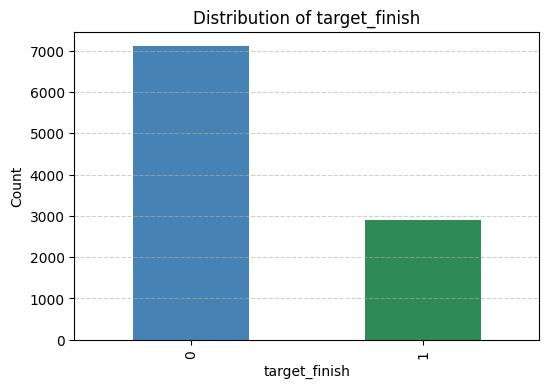

In [35]:
import matplotlib.pyplot as plt

# Tell forekomster
counts = data['target_finish'].value_counts().sort_index()

# Plot
plt.figure(figsize=(6,4))
counts.plot(kind='bar', color=['steelblue', 'seagreen'])

plt.title("Distribution of target_finish")
plt.xlabel("target_finish")
plt.ylabel("Count")
plt.xticks([0, 1], ["0", "1"])
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.show()

## **Part 2 - Training models**

### **Neural networks**

In this part of the project, we focus on Neural Networks. Broadly, neural network architectures can be divided into four major families: MLPs, RNNs, CNNs, and Transformers. Each of these architectures is designed to handle different data structures. Since our dataset does not contain sequential or spatial structure, there is no temporal dependency or context from one row to the next.

Because of this, architectures that rely on such structure—RNNs (designed for sequence modeling), CNNs (designed for spatial patterns), and Transformers (designed for long-range contextual dependencies)—are not suitable here. Instead, MLPs (Multi-Layer Perceptrons) are the most appropriate choice, as they perform best on tabular, independent samples where each row is treated as a standalone input.

In [15]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Define X and y 
X = data.drop(columns=['target_finish']).values
y = data['target_finish'].values


# Train/Test split

X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


# Train/Validation split

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full,
    test_size=0.2,
    random_state=42,
    stratify=y_train_full
)


# StandardScaler 
# Only fit on training set

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)


# Convert to PyTorch tensors

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X_val_tensor   = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor   = torch.tensor(y_val, dtype=torch.long)

X_test_tensor  = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor  = torch.tensor(y_test, dtype=torch.long)


# DataLoaders
# Shuffle only train

train_loader = DataLoader(
    TensorDataset(X_train_tensor, y_train_tensor),
    batch_size=32, shuffle=True
)

val_loader = DataLoader(
    TensorDataset(X_val_tensor, y_val_tensor),
    batch_size=32, shuffle=False
)

test_loader = DataLoader(
    TensorDataset(X_test_tensor, y_test_tensor),
    batch_size=32, shuffle=False
)

print("Train size:", X_train.shape)
print("Val size:", X_val.shape)
print("Test size:", X_test.shape)


Train size: (6400, 10)
Val size: (1600, 10)
Test size: (2000, 10)


In [ ]:
# IMPORTS

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras import models, layers



# ============================================
# PARAMETER GRID  (Lovlig og forbedret)
# ============================================

param_grid = {
    "depth": [
        [64],
        [128],
        [128, 64],
        [256, 128]
    ],

    "dropout": [
        0.0,
        0.05
    ],

    "activation": [
        tf.keras.activations.relu,
        tf.keras.activations.gelu
    ],

    "l2_reg": [
        0.0,
        1e-4
    ]
}


# ============================================
# PREPARE DATA
# ============================================

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)

input_dim = X_train_scaled.shape[1]



# ============================================
# BUILD MLP
# ============================================

def build_mlp(hidden_layers, activation, dropout, l2_reg):

    model = models.Sequential()
    model.add(layers.Input(shape=(input_dim,)))

    for h in hidden_layers:
        model.add(layers.Dense(
            h,
            activation=activation,
            kernel_regularizer=tf.keras.regularizers.l2(l2_reg)
        ))
        model.add(layers.Dropout(dropout))

    # Output layer
    model.add(layers.Dense(
        1,
        activation="sigmoid",
        kernel_regularizer=tf.keras.regularizers.l2(l2_reg)
    ))

    # IMPORTANT: Adam default (no LR tuning allowed)
    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    return model



# ============================================
# GRID SEARCH
# ============================================

results = []
best_model = None
best_history = None
best_val_acc = -1
model_id = 1

EPOCHS = 20
BATCH  = 32


for depth in param_grid["depth"]:
    for dropout in param_grid["dropout"]:
        for activation in param_grid["activation"]:
            for l2_reg in param_grid["l2_reg"]:

                print(f"\n=== MODEL {model_id} ===")
                print(f"Depth:      {depth}")
                print(f"Dropout:    {dropout}")
                print(f"Activation: {activation}")
                print(f"L2:         {l2_reg}")

                model = build_mlp(depth, activation, dropout, l2_reg)

                history = model.fit(
                    X_train_scaled, y_train,
                    validation_data=(X_val_scaled, y_val),
                    epochs=EPOCHS,
                    batch_size=BATCH,
                    verbose=0
                )

                val_acc = history.history["val_accuracy"][-1]
                print(f" → Validation accuracy: {val_acc:.4f}")

                # store result row
                results.append({
                    "model_id": model_id,
                    "depth": depth,
                    "dropout": dropout,
                    "activation": activation.__name__ if hasattr(activation, "__name__") else str(activation),
                    "l2_reg": l2_reg,
                    "val_acc": val_acc,
                    "history": history.history
                })

                # track best model
                if val_acc > best_val_acc:
                    best_val_acc = val_acc
                    best_model = model
                    best_history = history.history

                model_id += 1





=== MODEL 1 ===
Depth:      [64]
Dropout:    0.0
Activation: <function relu at 0x30896de40>
L2:         0.0
 → Validation accuracy: 0.7744

=== MODEL 2 ===
Depth:      [64]
Dropout:    0.0
Activation: <function relu at 0x30896de40>
L2:         0.0001
 → Validation accuracy: 0.7725

=== MODEL 3 ===
Depth:      [64]
Dropout:    0.0
Activation: <function gelu at 0x30916b2e0>
L2:         0.0
 → Validation accuracy: 0.7738

=== MODEL 4 ===
Depth:      [64]
Dropout:    0.0
Activation: <function gelu at 0x30916b2e0>
L2:         0.0001
 → Validation accuracy: 0.7738

=== MODEL 5 ===
Depth:      [64]
Dropout:    0.05
Activation: <function relu at 0x30896de40>
L2:         0.0
 → Validation accuracy: 0.7731

=== MODEL 6 ===
Depth:      [64]
Dropout:    0.05
Activation: <function relu at 0x30896de40>
L2:         0.0001
 → Validation accuracy: 0.7769

=== MODEL 7 ===
Depth:      [64]
Dropout:    0.05
Activation: <function gelu at 0x30916b2e0>
L2:         0.0
 → Validation accuracy: 0.7719

=== MOD

In [32]:

# SORT AND PRINT RESULTS


results_sorted = sorted(results, key=lambda x: x["val_acc"], reverse=True)

print("\n===============================")
print(" TOP MODELS")
print("===============================\n")

for r in results_sorted[:4]:
    print(f"Model {r['model_id']} — acc={r['val_acc']:.4f}")
    print(f"  depth={r['depth']}")
    print(f"  dropout={r['dropout']}")
    print(f"  activation={r['activation']}")
    print("---------------------------------")



 TOP MODELS

Model 10 — acc=0.7788
  depth=[128]
  dropout=0.0
  activation=relu
---------------------------------
Model 32 — acc=0.7788
  depth=[256, 128]
  dropout=0.05
  activation=gelu
---------------------------------
Model 8 — acc=0.7781
  depth=[64]
  dropout=0.05
  activation=gelu
---------------------------------
Model 14 — acc=0.7775
  depth=[128]
  dropout=0.05
  activation=relu
---------------------------------


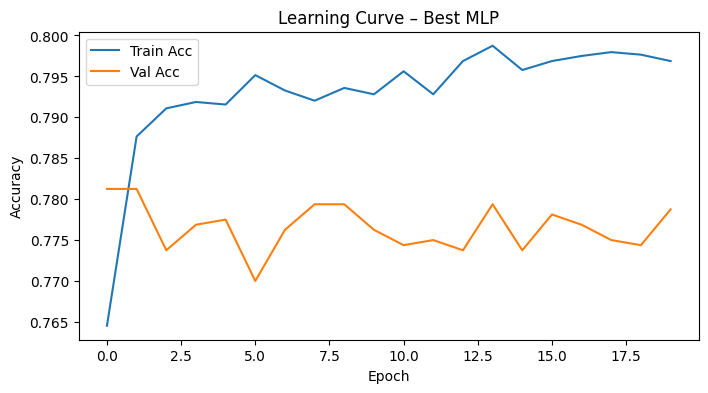

In [33]:
best = results_sorted[0]["history"]

plt.figure(figsize=(8,4))
plt.plot(best["accuracy"], label="Train Acc")
plt.plot(best["val_accuracy"], label="Val Acc")
plt.title("Learning Curve – Best MLP")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()


The learning rate appears to be relatively high, which results in noticeable fluctuations in the accuracy curve. However, we are required to use the default optimizer settings in this project, and therefore cannot adjust the learning rate.

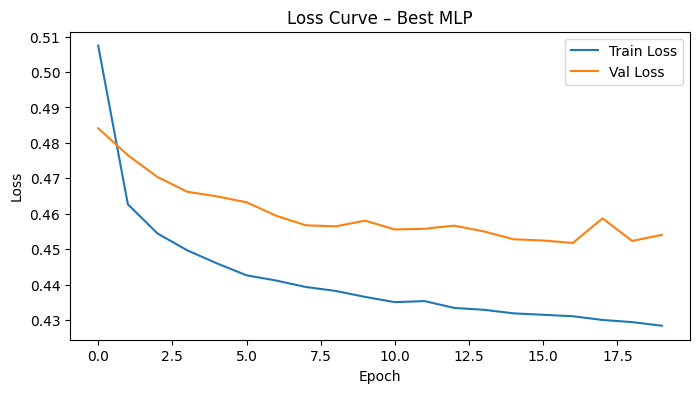

In [34]:
best = results_sorted[0]["history"]

plt.figure(figsize=(8,4))
plt.plot(best["loss"], label="Train Loss")
plt.plot(best["val_loss"], label="Val Loss")
plt.title("Loss Curve – Best MLP")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

The loss curves show a consistent downward trend for both the training and validation sets, indicating that the model continues to learn throughout the training process. Although the validation loss fluctuates slightly from epoch to epoch, this is expected given the relatively small validation set and the fixed optimizer settings required by the project. Overall, the training and validation loss follow similar trajectories, suggesting that the model generalizes reasonably well without severe overfitting.

In [24]:
best_model = build_mlp([128, 64], "relu", 0.0)

best_model.fit(
    X_train_scaled, y_train,
    epochs=EPOCHS,
    batch_size=BATCH,
    verbose=0
)

test_loss, test_acc = best_model.evaluate(X_test_scaled, y_test, verbose=0)
print("Test accuracy:", test_acc)


Test accuracy: 0.8054999709129333
